<a href="https://colab.research.google.com/github/Abinaya-J/Self_Driving_Car/blob/main/P3_Behavioral_Cloning_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Load data**

In [ ]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

--2021-06-26 15:58:59--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 99.86.227.118, 99.86.227.221, 99.86.227.5, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|99.86.227.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 317.70M  44.9MB/s    in 6.4s    

2021-06-26 15:59:06 (49.7 MB/s) - ‘data.zip’ saved [333137665/333137665]



In [ ]:
!unzip -qq data.zip

### Create train and test data

In [ ]:
import cv2
import csv
import pandas as pd
import numpy as np

In [ ]:
alldata = pd.read_csv('data/driving_log.csv')
display(alldata[0:5])#use alldata.head() simpler option :)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [ ]:
alldata.isna().sum().sum()

0

In [ ]:
lines=[]
with open('data/driving_log.csv') as csvfile:
  reader = csv.reader(csvfile)
  for line in reader:
    lines.append(line)

In [ ]:
images=[]
steering_m=[]
y=40
x=0
h=80
w=260
correction = 0.2
for line in lines[1:4001]:
  for i in range(3):
    path=line[i]
    filename= path.split('/')[-1]
    newpath = 'data/IMG/' + filename
    image = cv2.imread(newpath)
    image = cv2.resize(image, dsize = (260, 120))
    image = image[y:y+h, x:x+w]
    image = cv2.resize(image, dsize = (100, 100))
    # # image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    images.append(image)
    images.append(cv2.flip(image, 1))
  sm = float(line[3])
  left = sm + correction
  right = sm - correction
  steering_m.append(sm)
  steering_m.append(sm)
  steering_m.append(left)
  steering_m.append(left*-1.0)
  steering_m.append(right)    
  steering_m.append(right*-1.0)

In [ ]:
X_train = np.array(images)
Y_train = np.array(steering_m)

In [ ]:
print(len(X_train))
print(len(Y_train))

24000
24000


In [ ]:
print(X_train[0].shape)

(100, 100, 3)


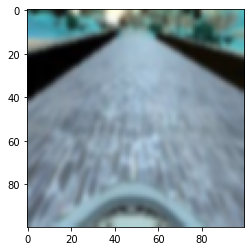

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

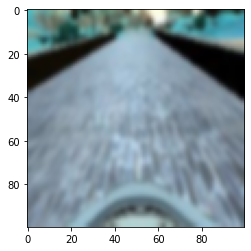

In [ ]:
plt.imshow(X_train[1])

In [ ]:
print(Y_train[1])

0.0


### Train and validate model

In [ ]:
import keras 
import pandas as pd
import tensorflow as tf

# Modelling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D, Input
from keras.initializers import glorot_uniform
from keras.optimizers import SGD , Adam
from keras.callbacks import LearningRateScheduler

NVIDIA Architechture

In [ ]:
model = Sequential([
    Lambda(lambda x : x/255.0 -0.5, input_shape=(100, 100, 3)),
    Conv2D(24, (5,5), (2,2) ,activation='relu'),
    Conv2D(36, (5,5), (2,2), activation='relu'),
    Conv2D(48, (5,5), (2,2), activation='relu'),
    Conv2D(64, (3,3), (2,2), activation='relu'),
    Conv2D(64, (3,3), (2,2), activation='relu'),
    
    Flatten(),    
    Dense(64,activation= 'relu'),
    Dense(32,activation= 'relu'),
    Dense(10,activation= 'relu'),
    Dense(1)])

In [ ]:
model1 = Sequential([
    Lambda(lambda x : x/255.0 -0.5, input_shape=(100, 100, 3)),                
    Conv2D(32, (5,5), activation='relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(32, (3,3), padding = 'same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding = 'same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Flatten(),    
    Dense(1164,activation= 'relu'),
    Dropout(0.5),
    Dense(512,activation= 'relu'),
    Dense(100,activation= 'relu'),
    Dropout(0.5),
    Dense(50,activation= 'relu'),
    Dropout(0.5),
    Dense(10,activation= 'relu'),
    Dropout(0.5),
    Dense(1)])

In [ ]:
model1.compile(loss='mse', optimizer = 'adam', metrics=["accuracy"])

In [ ]:
annealer = tf.keras.callbacks. LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [ ]:
history = model1.fit(X_train, Y_train, validation_split = 0.2, epochs=7, callbacks=[annealer], shuffle=True, batch_size = 32)

Epoch 1/7
600/600 [==============================] - 48s 77ms/step - loss: 28.3582 - accuracy: 0.1783 - val_loss: 0.0525 - val_accuracy: 0.1829
Epoch 2/7
600/600 [==============================] - 46s 77ms/step - loss: 0.0477 - accuracy: 0.1836 - val_loss: 0.0524 - val_accuracy: 0.1829
Epoch 3/7
600/600 [==============================] - 47s 78ms/step - loss: 0.0400 - accuracy: 0.1836 - val_loss: 0.0524 - val_accuracy: 0.1829
Epoch 4/7
600/600 [==============================] - 47s 78ms/step - loss: 0.0398 - accuracy: 0.1836 - val_loss: 0.0524 - val_accuracy: 0.1829
Epoch 5/7
600/600 [==============================] - 47s 79ms/step - loss: 0.0397 - accuracy: 0.1836 - val_loss: 0.0524 - val_accuracy: 0.1829
Epoch 6/7
600/600 [==============================] - 48s 79ms/step - loss: 0.0402 - accuracy: 0.1836 - val_loss: 0.0524 - val_accuracy: 0.1829
Epoch 7/7
600/600 [==============================] - 47s 78ms/step - loss: 0.0404 - accuracy: 0.1836 - val_loss: 0.0524 - val_accuracy: 0.182

In [ ]:
model1.save('model.h5')